Confounding
====

Date: October 9, 2014

Copyright (c) 2014 Rafael A. Irizarry MIT License

In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from pattern import web
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import binom
from __future__ import division
import re
from StringIO import StringIO
from zipfile import ZipFile 
from pandas import read_csv
from urllib import urlopen

#nice defaults for matplotlib
from matplotlib import rcParams

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

/Users/tomasz.dobrzycki/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
zip_folder = requests.get('http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip').content
zip_files = StringIO()
zip_files.write(zip_folder)
csv_files = ZipFile(zip_files)

In [3]:
teams = csv_files.open('Teams.csv')
teams = read_csv(teams)

In [4]:
dat = teams[(teams['G']==162) & (teams['yearID'] < 2002)]
dat['Singles'] = dat['H']-dat['2B']-dat['3B']-dat['HR']
dat = dat[['R','Singles', 'HR', 'BB']]
dat.head(5)

/Users/tomasz.dobrzycki/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,R,Singles,HR,BB
437,505,997,11,344
1366,744,902,189,681
1367,683,989,90,580
1377,817,1041,199,584
1379,718,973,137,602


Are BB more valuable than singles?
====

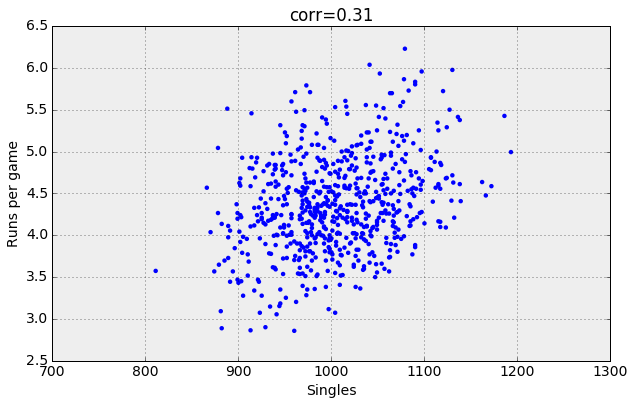

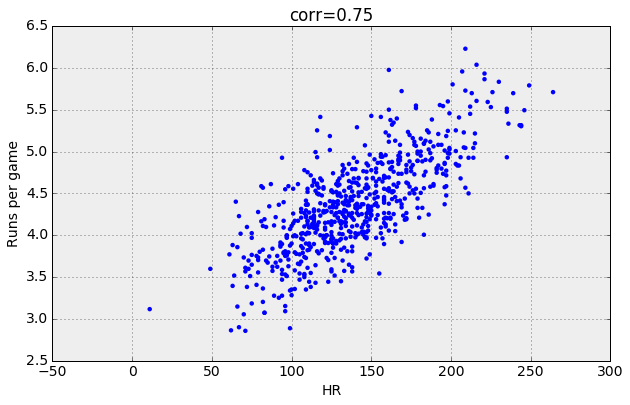

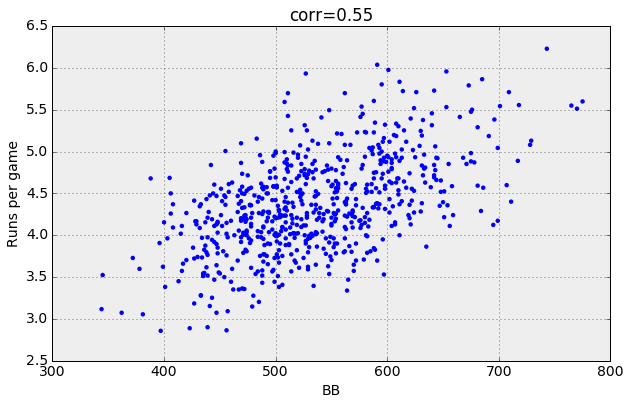

In [5]:
for col in dat.columns[1:]:
    plt.scatter(dat[col], dat["R"]/162)
    plt.xlabel(col)
    plt.ylabel("Runs per game")
    plt.title("corr="+str(round(np.corrcoef(dat[col],dat["R"])[0][1],2)))
    plt.show()
    

Confounding
===

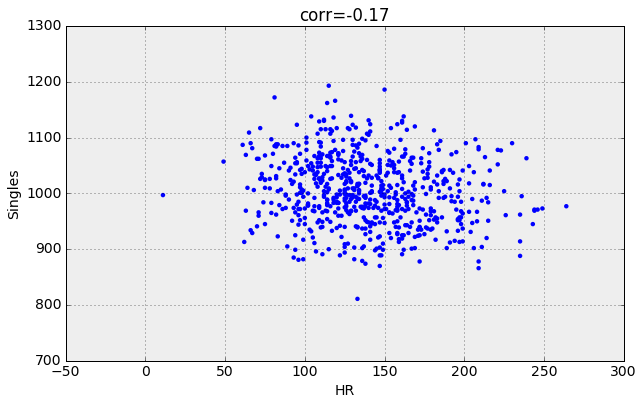

In [6]:
plt.scatter(dat["HR"], dat["Singles"])
plt.xlabel("HR")
plt.ylabel("Singles")
plt.title("corr="+str(round(np.corrcoef(dat['Singles'],dat['HR'])[0][1],2)))
plt.show()

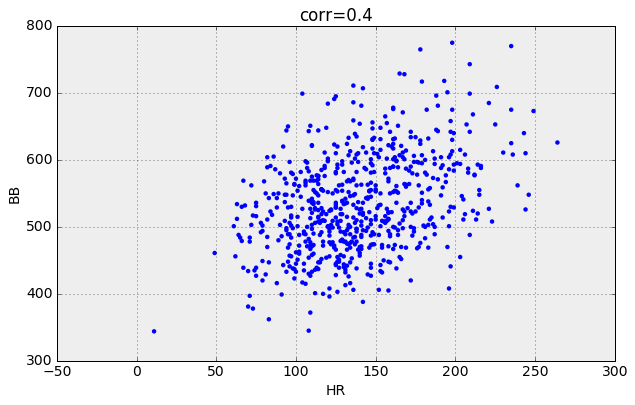

In [7]:
plt.scatter(dat['HR'], dat['BB'])
plt.xlabel("HR")
plt.ylabel("BB")
plt.title("corr="+str(round(np.corrcoef(dat['HR'],dat['BB'])[0][1],2)))
plt.show()

Adjusting with Regression 
====

A popular approach, although not always recommended, is to use regression models to "adjust"

Here are the regression coefficients with a BB only model:

In [8]:
Y = dat["R"].values
X = np.transpose(dat["BB"].values)
X = sm.add_constant(X)
params = sm.OLS(Y,X).fit().params
print "Intercept:", params[0]
print "BB:", params[1]

Intercept: 326.824162794
BB: 0.712640162083


In [9]:
X = np.transpose(np.array([dat["BB"].values, dat["HR"].values]))
X = sm.add_constant(X)
params = sm.OLS(Y,X).fit().params
print "Intercept:", params[0]
print "BB:", params[1]
print "HR:", params[2]

Intercept: 287.722675631
BB: 0.389717793133
HR: 1.522044808


Association is not causation
===
![corr not causation 1](http://i.imgur.com/wuFRozj.png)

Association is not causation
===
![corr not causation 2](http://i.imgur.com/xqOt9mP.png)

For more spurious correlations go [here](http://www.tylervigen.com)

Correlation by HR strata
====
Divide each team intro 10 strata, top 10%, second 20% etc... Then compute the correlation in each strata

In [10]:
qs = [round(np.percentile(dat['HR'], x), 1) for x in np.arange(0,110, 10)]

In [11]:
def get_interval(x):
    for i in range(1, len(qs)):
        if x-qs[i]<0:
            return i
    return len(qs)-1
indexes = {}
for i in range(1, len(qs)):
    indexes[i] = []
for idx in dat.index:
    interval = get_interval(dat.loc[idx]['HR'])
    indexes[interval].append(idx)

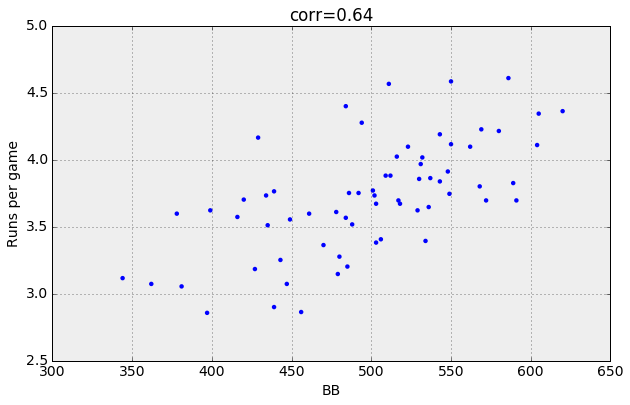

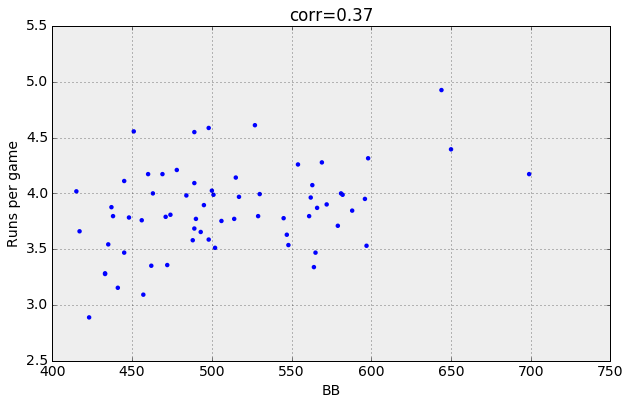

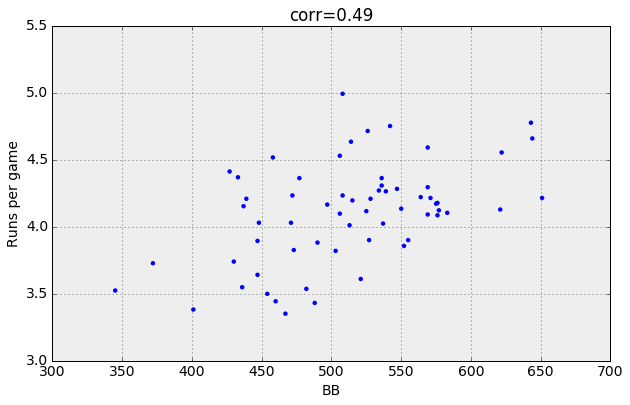

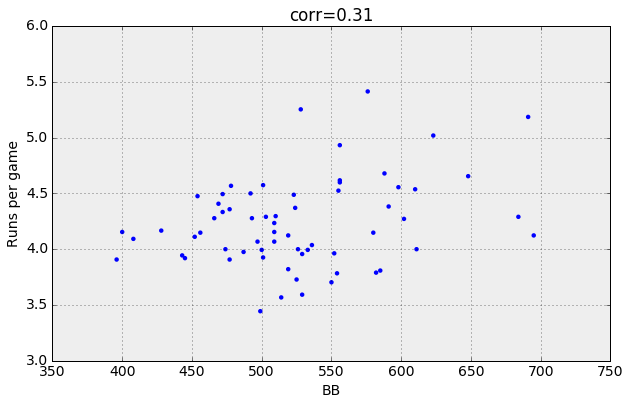

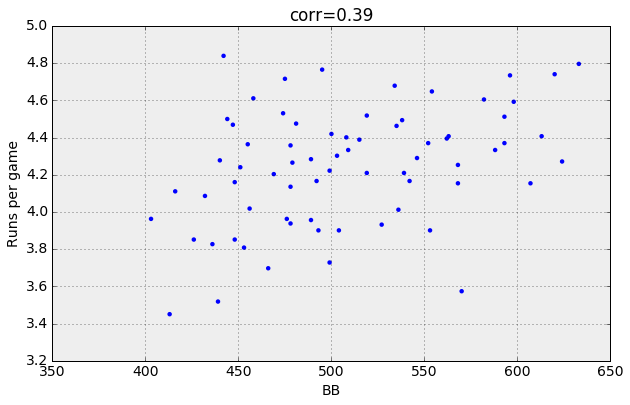

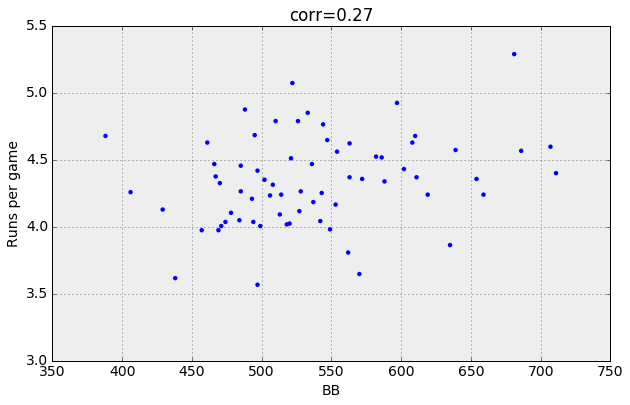

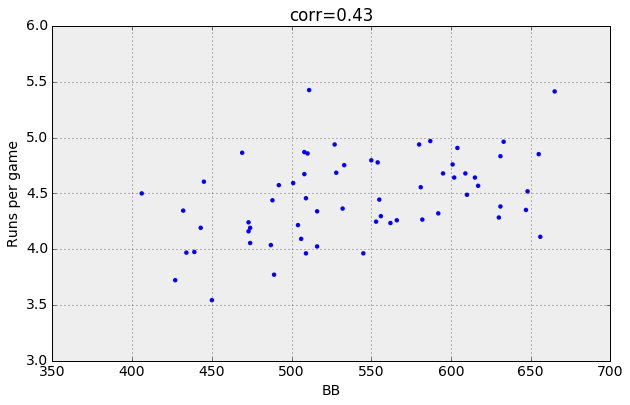

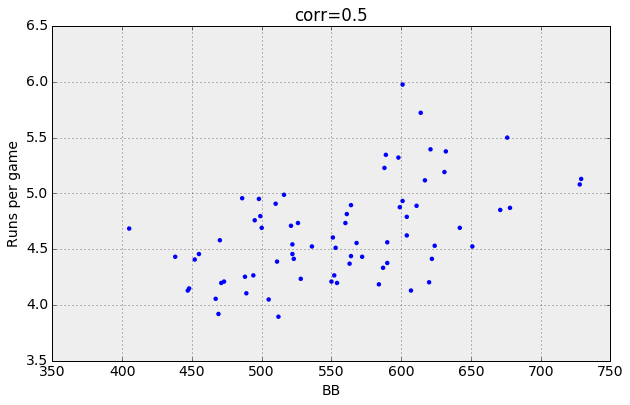

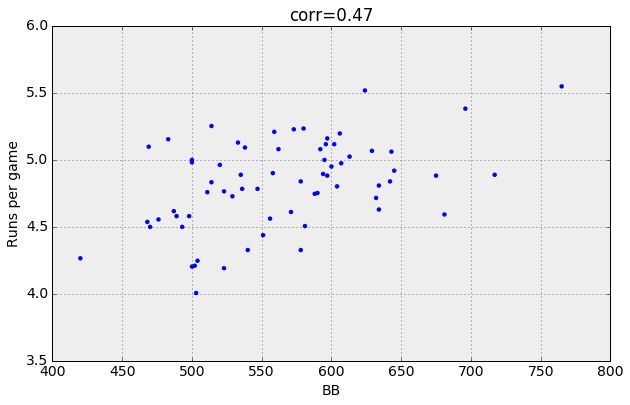

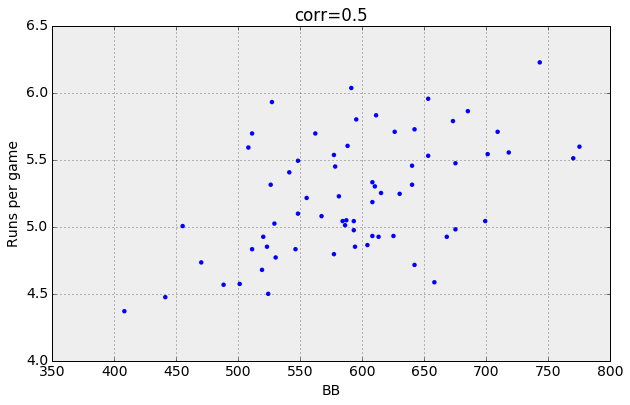

In [12]:
for i in range(1, len(indexes)+1):
    df = dat.loc[indexes[i]]
    plt.scatter(df['BB'], df["R"]/162)
    plt.xlabel('BB')
    plt.ylabel("Runs per game")
    plt.title("corr="+str(round(np.corrcoef(df['BB'],df['R'])[0][1],2)))
    plt.show()  

More examples
===
* The more firemen are sent to a fire, the more damage is done.

* Children who get tutored get worse grades than children who do not get tutored

* In the early elementary school years, astrological sign is correlated with IQ, but this correlation weakens with age and disappears by adulthood.

From [Peter Flom](http://stats.stackexchange.com/posts/18074/revisions)
Admission 
===

* Admission data from Berkeley 1973 showed 44% men admitted compared to 30% women.

In [336]:
datafile = "http://www.biostat.jhsph.edu/bstcourse/bio751/data/admissions.csv"
page = urlopen(datafile)
dat = read_csv(page)
dat.head(3)

,Major,Number,Percent,Gender
0,A,825,62,1
1,B,560,63,1
2,C,325,37,1


In [337]:
dat['total'] = dat['Percent']*dat['Number']/100

In [338]:
print 'Percent men get in:',round(np.sum(dat[dat['Gender']==1]['total']/
                                   np.sum(dat[dat['Gender']==1]['Number']))*100,1)
print 'Percent women get in:',round(np.sum(dat[dat['Gender']==0]['total']/
                                   np.sum(dat[dat['Gender']==0]['Number']))*100,1)

Percent men get in: 44.5
Percent women get in: 30.3


* All things being equal, the probability of this happening by chance  is much less than 1 in a million.

In [339]:
tab = []
males = dat[dat['Gender']==1]
tab.append([round(np.sum(males['Number']*males['Percent']/100)), 
           round(np.sum(males['Number']*(1-males['Percent']/100)))])
females = dat[dat['Gender']==0]
tab.append([round(np.sum(females['Number']*females['Percent']/100)), 
           round(np.sum(females['Number']*(1-females['Percent']/100)))])

In [340]:
print 'p-value =', stats.chi2_contingency(tab)[1]

p-value = 1.05579680878e-21


PJ Bickel, EA Hammel, and JW O'Connell. Science (1975)

Simpson's Paradox
====

* Closer inspection shows a paradoxical results. 

* Here are the percent admissions by major:

In [341]:
df = males[['Major', 'Percent']]
df['Female'] = dat[dat['Gender']==0]['Percent'].values
df.columns = ['Major', 'Male', 'Female']
df

,Major,Male,Female
0,A,62,82
1,B,63,68
2,C,37,34
3,D,33,35
4,E,28,24
5,F,6,7


What's going on? 
=====
* This is called _Simpson's paradox_ 

* Note there are "easy" majors and some confounding 

In [342]:
y = pd.DataFrame(columns = ['Major', 'Total Male', 'Total Female'])
y['Major'] = males['Major']
y['Total Male'] = males['total'].values/sum(males['total'].values)*100
y['Total Female'] = females['total'].values/sum(females['total'])*100
x = (df['Male']+df['Female'])/2

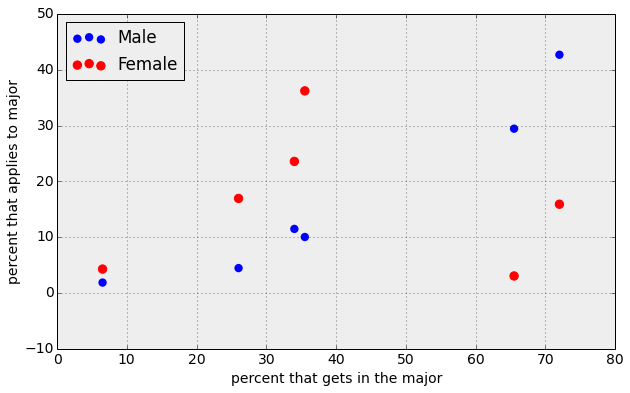

In [343]:
plt.scatter(x,y['Total Male'], s = 70, label = "Male")
plt.scatter(x,y['Total Female'], s = 70, color = 'red', label = "Female")
plt.xlabel("percent that gets in the major")
plt.ylabel("percent that applies to major")
plt.legend(loc = 'upper left')
plt.show()


Confounding explained
===

In [344]:
males['total'] = np.array([round(a) for a in males['total'].values]) 
males['rejected'] = males['Number']-males['total']
females['total'] = np.array([round(a) for a in females['total'].values]) 
females['rejected'] = females['Number']-females['total']


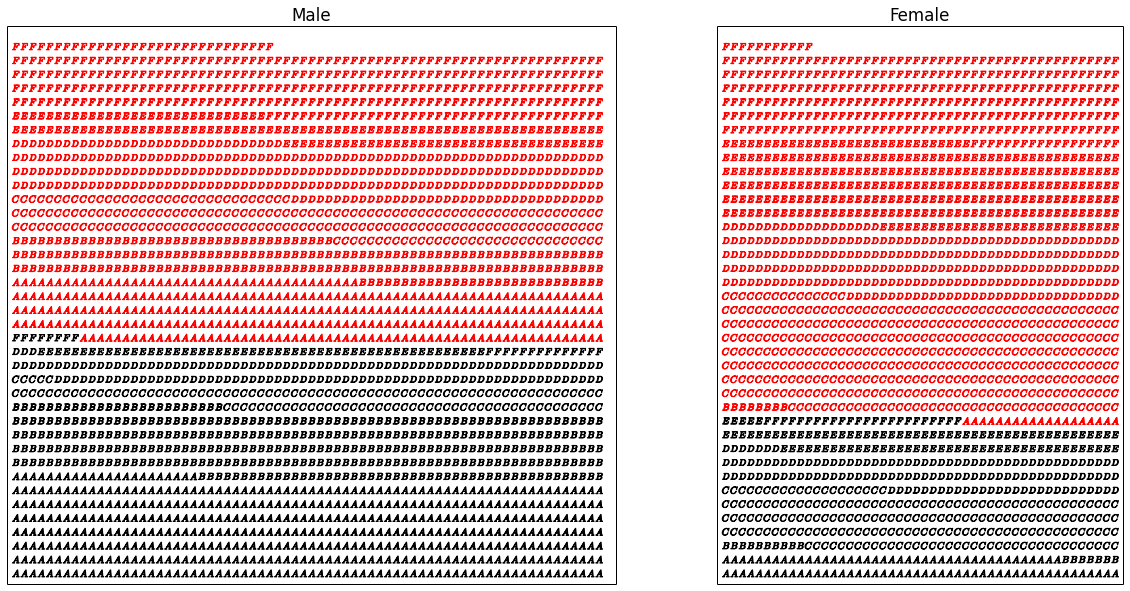

In [352]:
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1]) 

rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'White'
rcParams['figure.figsize'] = (20, 10)

plt.figure(1)
plt.subplot(gs[0])

plt.xlim(0,72)
plt.ylim(-0.5,80)
plt.title('Male')
plt.xticks([])
plt.yticks([])

majors = ['A', 'B', 'C', 'D', 'E', 'F']
c = 1
r = 1
for major in majors:
    n = males[males['Major']==major]['total'].values[0]
    while(n>0):
        plt.scatter(c, r, s = 50, marker = "$ {} $".format(major), color = 'black')
        c+=1
        if(c>70):
            c = 1
            r+= 2
        n-=1
for major in majors:
    n = males[males['Major']==major]['rejected'].values[0]
    while(n>0):
        plt.scatter(c, r, s = 50, marker = "$ {} $".format(major), color = 'red')
        c+=1
        if(c>70):
            c = 1
            r+= 2
        n-=1
        
plt.subplot(gs[1])
rcParams['figure.figsize'] = (6, 10)

plt.xlim(0,49)
plt.ylim(-0.5,80)
plt.title('Female')
plt.xticks([])
plt.yticks([])

c = 1
r = 1
for major in majors:
    n = females[females['Major']==major]['total'].values[0]
    while(n>0):
        plt.scatter(c, r, s = 50, marker = "$ {} $".format(major), color = 'black')
        c+=1
        if(c>48):
            c = 1
            r+= 2
        n-=1
for major in majors:
    n = females[females['Major']==major]['rejected'].values[0]
    while(n>0):
        plt.scatter(c, r, s = 50, marker = "$ {} $".format(major), color = 'red')
        c+=1
        if(c>48):
            c = 1
            r+= 2
        n-=1

Confounding explained
===

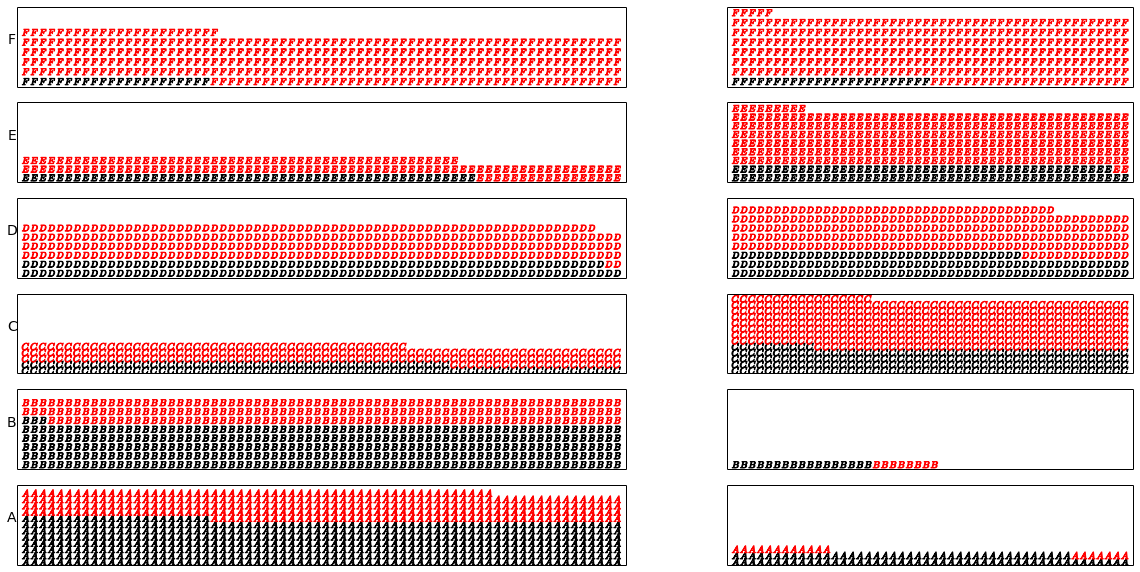

In [353]:
rcParams['figure.figsize'] = (20, 10)
plt.figure(1)
majors.reverse()
gs = gridspec.GridSpec(6, 2, width_ratios=[1.5, 1]) 

figure = 0
for major in majors:
    
    plt.subplot(gs[figure])
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(major, rotation = 0)
    
    ymax = max((males[males['Major']==major]['total'].values[0]
         +males[males['Major']==major]['rejected'].values[0])/70, 
              (females[females['Major']==major]['total'].values[0]
         +females[females['Major']==major]['rejected'].values[0])/48)
    ymax = (ymax+1)*2
    
    c = 1
    r = 1
    n = males[males['Major']==major]['total'].values[0]
    while(n>0):
        plt.scatter(c, r, s = 50, marker = "$ {} $".format(major), color = 'black')
        c+=1
        if(c>70):
            c = 1
            r+= 2
        n-=1
    n = males[males['Major']==major]['rejected'].values[0]
    while(n>0):
        plt.scatter(c, r, s = 50, marker = "$ {} $".format(major), color = 'red')
        c+=1
        if(c>70):
            c = 1
            r+= 2
        n-=1
    plt.xlim(0,71)
    plt.ylim(0,ymax)
        
    figure+=1
    plt.subplot(gs[figure])
    plt.xticks([])
    plt.yticks([])
    
    c = 1
    r = 1
    n = females[females['Major']==major]['total'].values[0]
    while(n>0):
        plt.scatter(c, r, s = 50, marker = "$ {} $".format(major), color = 'black')
        c+=1
        if(c>48):
            c = 1
            r+= 2
        n-=1
    n = females[females['Major']==major]['rejected'].values[0]
    while(n>0):
        plt.scatter(c, r, s = 50, marker = "$ {} $".format(major), color = 'red')
        c+=1
        if(c>48):
            c = 1
            r+= 2
        n-=1
        
    plt.xlim(0,49)
    plt.ylim(0,ymax)
    
    figure+=1



Stratified Analysis
===

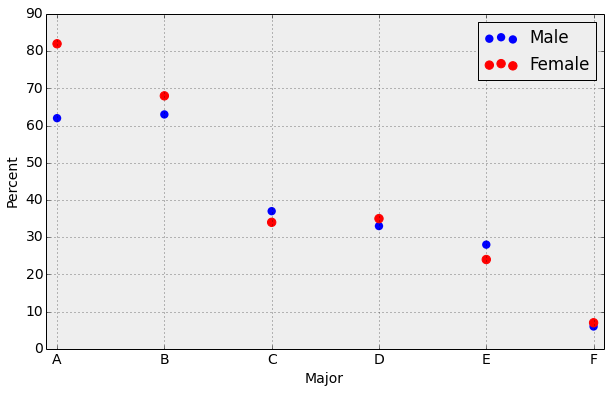

In [354]:
rcParams['figure.figsize'] = (10, 6)
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'

x = range(1,7)
majors.reverse()
plt.scatter(x,males['Percent'], s = 70, label = "Male")
plt.scatter(x,females['Percent'], s = 70, color = 'red', label = "Female")
plt.xlabel("Major")
plt.ylabel("Percent")
plt.xlim(0.9, 6.1)
plt.xticks(x, majors)
plt.legend(loc = 'upper right')
plt.show()

The average difference by major is 3.5% higher for women.

In [355]:
print "male-female difference:",np.mean(males['Percent'].values-females['Percent'].values)

male-female difference: -3.5
